# Setup Enviornment

Linux\Unix\Mac
```bash
python3 -m venv .venv
source .venv/bin/activate
python3 -m pip install -r requirements.txt
```
Windows
```bash
python3 -m venv .venv
.venv\Scripts\activate
python3 -m pip install -r requirements.txt
```

Using device NVIDIA GeForce RTX 4070 Ti
30
30


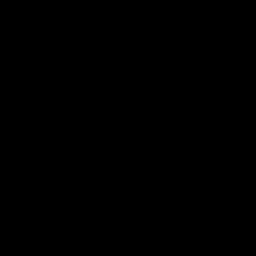

In [6]:
import compushady.config
import compushady.formats
import compushady
from compushady.shaders import hlsl
import struct
import platform
import math
from PIL import Image
from IPython.display import Image as IPy_Image

import os
#import sys
import pathlib

compushady.config.set_debug(True)

print('Using device', compushady.get_current_device().name)

target = compushady.Texture2D(256, 256, compushady.formats.R8G8B8A8_UNORM)

buffer = compushady.Buffer(target.size, compushady.HEAP_READBACK)

# use 16 to make d3d11 happy...
config = compushady.Buffer(16, compushady.HEAP_UPLOAD)

config_fast = compushady.Buffer(config.size)

shader = hlsl.compile("""
cbuffer Config : register(b0)
{
    float multiplier;
};

RWTexture2D<float4> target : register(u0);

float mandlebrot(float2 xy)
{
    const uint max_iterations = 100;
    xy = (xy - 0.5) * 2 - float2(1, 0);
    float2 z = float2(0, 0);
    for(uint i = 0; i < max_iterations; i++)
    {
        z = float2(z.x * z.x - z.y * z.y, z.x * z.y * 2) + xy;
        if (length(z) > multiplier * 2) return float(i) / max_iterations;
    }

    return 1; // white
 }

float3 color_map(float t)
{
    // t is in the range [0, 1], map it to a color
    float3 color;
    color.x = 0.1 + 0.5 * cos(6.28318 * t + 0.0);
    color.y = 0.5 + 0.7 * cos(6.28318 * t + 2.09439);
    color.z = 0.7 + 0.6 * cos(6.28318 * t + 4.18878);
    return color;
}

[numthreads(8,8,1)]
void main(int3 tid : SV_DispatchThreadID)
{
    uint width;
    uint height;
    target.GetDimensions(width, height);
    float2 xy = tid.xy / float2(width, height);
    float m = mandlebrot(xy);
    float3 color = color_map(m);
    target[tid.xy] = float4(color,1) * float4(multiplier,multiplier,multiplier, 1);
}
""")

shader2 = hlsl.compile("""
cbuffer Config : register(b0)
{
    float multiplier;
};

RWTexture2D<float4> target : register(u0);
                       
float3 palette( float t ) {
    float3 a = multiplier * float3(0.5, 0.5, 0.5);
    float3 b = multiplier * float3(0.5, 0.5, 0.5);
    float3 c = multiplier * float3(1.0, 1.0, 1.0);
    float3 d = multiplier * float3(0.263,0.416,0.557);

    return a + b*cos( 6.28318*(c*t+d) );
}
[numthreads(8,8,1)]
void main(int3 tid : SV_DispatchThreadID) {
    uint width;
    uint height;
    target.GetDimensions(width, height);
    float2 xy = tid.xy / float2(width, height);
                       
    float2 uv = (xy * 2.0 - tid.xy) / tid.y;
    float2 uv0 = uv;
    float3 finalColor = float3(0.0,0.0,0.0);
                       
    for (float i = 0.0; i < 4.0; i++) {
        uv = frac(uv * 1.5) - 0.5;
        float d = length(uv) * exp(-length(uv0));
        
        float3 col = palette(length(uv0) + i*.4);
        d = sin(d*8.)/8.;

        d = abs(d);

        d = pow(0.01 / d, 1.2);

        finalColor += col * d;
    }
        
    target[tid.xy] = float4(finalColor, 1.0);
}
""")
computes = [
    compushady.Compute(shader, cbv=[config_fast], uav=[target]),
    compushady.Compute(shader2, cbv=[config_fast], uav=[target])
]

count = 0
for compute in computes:
    multiplier = 0
    images = []
    for i in range(0, 30):
        config.upload(struct.pack('f', abs(math.sin(multiplier))))
        config.copy_to(config_fast)
        compute.dispatch(target.width // 8, target.height // 8, 1)
        target.copy_to(buffer)
        image = Image.new('RGBA', (target.width, target.height))
        image.frombytes(buffer.readback())
        images.append(image)
        multiplier += 0.1

    print(len(images))
    img_out_dir = os.path.join(pathlib.Path().resolve(),'img_output')
    os.makedirs(img_out_dir, exist_ok=True)
    img_path =  os.path.join(img_out_dir,f'compushady_{count}.gif')
    images[0].save(img_path,
               save_all=True, append_images=images[1:], optimize=False, duration=150, loop=0)
    count = count + 1
IPy_Image(filename=os.path.join(pathlib.Path().resolve(),'img_output/compushady_0.gif'))

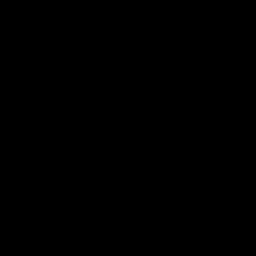

In [7]:
IPy_Image(filename=os.path.join(pathlib.Path().resolve(),'img_output/compushady_1.gif'))